# References 
1. Data source: https://www.kaggle.com/nasa/kepler-exoplanet-search-results
2. Column explenation (not complete): https://keplerexoplanets.readthedocs.io/en/latest/dataset.html
3. Column explenation (from a repo): https://github.com/bnarath/find_Exoplanet
4. Column explenation (NASA web): https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html
5. Exoplanet explenation: https://exoplanets.nasa.gov/what-is-an-exoplanet/overview/

## Import Libraries

In [190]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score 

sns.set()
%matplotlib inline

In [191]:
df = pd.read_csv('cumulative.csv', sep=',')
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## Inspect and Explore the Data

##### We start with over 9,000 rows

In [192]:
df.shape

(9564, 50)

##### The non-number columns are the names of the KOI (2 columns), the label for each KOI (2 columns) and the TCE delivery name (column 37)¶


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

##### Remove the following columns as they don't give us any computational power. We remove the koi_score column because it represents the confidence level that a KOI (Kepler Object of Interest) is a planet.

In [194]:
df = df.drop(['rowid','kepler_name','koi_pdisposition','koi_score','koi_tce_delivname','koi_teq_err1','koi_teq_err2'], 1)
df.head()

,kepid,kepoi_name,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,CONFIRMED,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,FALSE POSITIVE,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,CONFIRMED,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [195]:
df.shape

(9564, 43)

In [196]:
df = df.dropna()
df.shape

(8744, 43)

##### Our goal is to compute if a KOI is or is not a planet. The koi_disposition column has three values which are the following:

##### The CONFIRMED KOI are the planets that have passed all the Kepler's test and are verified by NASA's database. The FALSE POSSITIVE KOI is an object which is NOT a planet. The CANDIDATE KOI is a object that has not yet passed all the Kepler's test.

In [197]:
df['koi_disposition'].value_counts()

FALSE POSITIVE    4358
CONFIRMED         2272
CANDIDATE         2114
Name: koi_disposition, dtype: int64

In [199]:
condition = df['koi_disposition'] == 'CANDIDATE'
df_candidate = df[condition]
df_candidate.head()

,kepid,kepoi_name,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
37,11138155,K00760.01,CANDIDATE,0,0,0,0,4.959319,5.150000e-07,-5.150000e-07,...,-77.0,4.359,0.110,-0.110,1.082,0.173,-0.130,292.16705,48.727589,15.263
58,11818800,K00777.01,CANDIDATE,0,0,0,0,40.419504,1.139000e-04,-1.139000e-04,...,-163.0,4.507,0.116,-0.105,0.781,0.116,-0.095,294.31686,50.080231,15.487
62,11918099,K00780.02,CANDIDATE,0,0,0,0,7.240661,1.617000e-05,-1.617000e-05,...,-79.0,4.595,0.012,-0.064,0.765,0.055,-0.028,293.83331,50.230350,15.334
63,9579641,K00115.03,CANDIDATE,0,0,0,0,3.435916,4.729000e-05,-4.729000e-05,...,-115.0,4.339,0.132,-0.108,1.087,0.157,-0.142,287.88733,46.276241,12.791
72,3246984,K00799.01,CANDIDATE,0,0,0,0,1.626630,1.015000e-06,-1.015000e-06,...,-172.0,4.410,0.124,-0.186,0.973,0.270,-0.145,294.36819,38.310280,15.279


In [200]:
name = df_candidate['kepoi_name'].tolist() 

In [201]:
df = df.drop(['kepoi_name'], 1); #if the column is not removed an error happend in the dummy function
df.head()

,kepid,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,CONFIRMED,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,FALSE POSITIVE,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,CONFIRMED,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [202]:
df_candidate.shape

(2114, 43)

In [204]:
#df_candidate.isnull().sum()

##### In this model we will remove the CANDIDATE KOIs (all 2248 of them). Now, we create a dummy table for column 'koi_disposition'. 

In [205]:
df.drop(df[df['koi_disposition'] == 'CANDIDATE'].index, inplace = True)
df = pd.get_dummies(df, 'koi_disposition', drop_first=True)
df.rename(columns = {'koi_disposition_FALSE POSITIVE':'koi_confirmed'}, inplace = True)
df.head()


,kepid,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,koi_confirmed
0,10797460,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,...,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,0
1,10797460,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,0
2,10811496,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,...,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,1
3,10848459,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,1
4,10854555,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,...,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,0


In [206]:
#koi_confirmed = 1 -> planet
#koi_confirmed = 0 -> false positive

c1 = df['koi_confirmed'] == 0
df['koi_confirmed'] = np.where(c1, 1, 0)
df.head()

,kepid,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,koi_confirmed
0,10797460,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,...,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1
1,10797460,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1
2,10811496,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,...,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,0
3,10848459,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0
4,10854555,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,...,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,1


##### Check for duplicated rows and columns that have null values

In [86]:
df.duplicated().sum()

0

## Now we are ready to build out Decision Tree Classifier

##### The featuers of out model will be all the columns except the id and prediction column respectively the first and last column

In [88]:
features = df.columns
features = features.delete(0)
features = features.delete(len(features)-1)
print(list(features))

['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']


##### Preparing and seperating the data to be fed to the model

In [106]:
X = df[features]
y = df['koi_confirmed']

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

print('Lenght of our Training data:', X_sm.shape, '\nLength of our Testing data:', y_sm.shape)
print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Lenght of our Training data: (8716, 40) 
Length of our Testing data: (8716,)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: koi_confirmed, dtype: float64

##### Creating the model and fitting the data

In [107]:

# The params is a dictionary.  
# Where the keys are the parameter, 
# and the values are lists of parameter settings to try as values.
params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': [2, 5, 6, 7 ,8 , 9, 10], 
    'min_samples_split': [2, 10, 20, 30],
    'min_samples_leaf': [1, 10, 20, 30],
         }

# Pass in an empty Decision Tree (empty excluding the random_state).
# The parameter dictionary
# and the scoring you want to optimize for. 
grid_search_cv =  GridSearchCV( 
    estimator = DecisionTreeClassifier(), 
    param_grid = params, 
    scoring = 'f1')


# Now, with one easy command, fit all combination of trees. 
grid_search_cv.fit(X_sm, y_sm)

# Print the best parameters it found
print(grid_search_cv.best_params_)

# This command gives you the best tree
model = grid_search_cv.best_estimator_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 10}


In [207]:
# Now lets evaluate our model

X_test_c = df_candidate[features]
y_pred = model.predict(X_test_c)


In [208]:

id_list = df_candidate['kepid'].tolist()
name_list = name
pred_list = list(y_pred)
list_of_tuples = list(zip(id_list, name_list, pred_list))
df_pred = pd.DataFrame(list_of_tuples, columns = ['id', 'name', 'prediction']) 


In [209]:
df_pred.head(30)

,id,name,prediction
0,11138155,K00760.01,1
1,11818800,K00777.01,1
2,11918099,K00780.02,0
3,9579641,K00115.03,1
4,3246984,K00799.01,1
5,3115833,K00797.01,1
6,3453214,K00802.01,1
7,3641726,K00804.01,1
8,3940418,K00810.01,1
9,4544670,K00815.01,1


In [210]:
latest_df = pd.read_csv('final-data.csv', sep=',')
latest_df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,11446443,K00001.01,Kepler-1 b,CONFIRMED,Done,8/16/18,CANDIDATE,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,10666592,K00002.01,Kepler-2 b,CONFIRMED,Done,8/16/18,CANDIDATE,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,10748390,K00003.01,Kepler-3 b,CONFIRMED,Done,8/16/18,CANDIDATE,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3861595,K00004.01,Kepler-1658 b,CONFIRMED,Done,8/16/18,CANDIDATE,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,8554498,K00005.01,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
df_candidate.head()

,kepid,kepoi_name,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
37,11138155,K00760.01,CANDIDATE,0,0,0,0,4.959319,5.150000e-07,-5.150000e-07,...,-77.0,4.359,0.110,-0.110,1.082,0.173,-0.130,292.16705,48.727589,15.263
58,11818800,K00777.01,CANDIDATE,0,0,0,0,40.419504,1.139000e-04,-1.139000e-04,...,-163.0,4.507,0.116,-0.105,0.781,0.116,-0.095,294.31686,50.080231,15.487
62,11918099,K00780.02,CANDIDATE,0,0,0,0,7.240661,1.617000e-05,-1.617000e-05,...,-79.0,4.595,0.012,-0.064,0.765,0.055,-0.028,293.83331,50.230350,15.334
63,9579641,K00115.03,CANDIDATE,0,0,0,0,3.435916,4.729000e-05,-4.729000e-05,...,-115.0,4.339,0.132,-0.108,1.087,0.157,-0.142,287.88733,46.276241,12.791
72,3246984,K00799.01,CANDIDATE,0,0,0,0,1.626630,1.015000e-06,-1.015000e-06,...,-172.0,4.410,0.124,-0.186,0.973,0.270,-0.145,294.36819,38.310280,15.279


In [211]:
latest_df = latest_df[['kepid', 'kepoi_name', 'koi_disposition']]
latest_df.head()

,kepid,kepoi_name,koi_disposition
0,11446443,K00001.01,CONFIRMED
1,10666592,K00002.01,CONFIRMED
2,10748390,K00003.01,CONFIRMED
3,3861595,K00004.01,CONFIRMED
4,8554498,K00005.01,CANDIDATE


In [212]:
latest_df['koi_disposition'].value_counts()

FALSE POSITIVE    4840
CANDIDATE         2366
CONFIRMED         2358
Name: koi_disposition, dtype: int64

In [129]:
df_pred.head()

,id,name,prediction
0,11138155,K00760.01,1
1,11818800,K00777.01,1
2,11918099,K00780.02,0
3,9579641,K00115.03,1
4,3246984,K00799.01,1


In [173]:
true_label = 0
true_list = list()
false_label = 0
false_list = list()
no_label = 0

predictions = df_pred['name'].tolist()
for name in predictions:
    cond1 = latest_df['kepoi_name'] == name
    cond2 = df_pred['name'] == name
    
    truth = latest_df.loc[cond1, ['koi_disposition']].koi_disposition.item()
    our_pred = df_pred.loc[cond2, ['prediction']].prediction.item()
    
    if truth == 'CONFIRMED':
        if our_pred == 1:
            true_label = true_label + 1
            true_list.append(name)
        elif our_pred == 0:
            false_label = false_label + 1
            false_list.append(name)
    elif truth == 'FALSE POSITIVE':
        if our_pred == 1:
            false_label = false_label + 1
            false_list.append(name)
        elif our_pred == 0:
            true_label = true_label + 1
            true_list.append(name)
    else:
        no_label = no_label + 1


In [163]:
print(true_label)

115


In [174]:
print(true_list)

['K00892.02', 'K00145.01', 'K00977.01', 'K01075.01', 'K00945.01', 'K00945.02', 'K01165.01', 'K01311.01', 'K01448.01', 'K01296.01', 'K01563.03', 'K01230.01', 'K01738.01', 'K01747.01', 'K00182.01', 'K01470.01', 'K01539.01', 'K01475.02', 'K01541.01', 'K01545.01', 'K01705.01', 'K01599.01', 'K01892.01', 'K01984.01', 'K02066.01', 'K01928.01', 'K01783.01', 'K01863.01', 'K01822.01', 'K01889.02', 'K02106.01', 'K02120.01', 'K02132.01', 'K02293.01', 'K02076.01', 'K02229.01', 'K02559.01', 'K02417.01', 'K02504.01', 'K02588.01', 'K00004.01', 'K00252.01', 'K02398.01', 'K02626.01', 'K02849.01', 'K02871.01', 'K02878.01', 'K02733.01', 'K02755.01', 'K02757.01', 'K00367.01', 'K00326.01', 'K00326.02', 'K03048.01', 'K00280.01', 'K00347.01', 'K00349.01', 'K00555.02', 'K00089.02', 'K00547.03', 'K00691.01', 'K00650.01', 'K00619.01', 'K04054.01', 'K04386.01', 'K02433.03', 'K04550.01', 'K03520.01', 'K01781.03', 'K03572.01', 'K03361.01', 'K03680.01', 'K03681.02', 'K03849.01', 'K03864.01', 'K03890.01', 'K01807.01'

In [164]:
false_label

87

In [165]:
no_label

1912

In [167]:
1912 + 87 + 115

2114

In [171]:
df_candidate['kepid'].count()

2114

In [49]:
X_test_cc = df_candidate[features]
y_pred_proba = model.predict_proba(X_test_cc)[:,1]
count = 0
for i in y_pred_proba:
    #print(i)
    if i > 0.6:
        count = count + 1
print(count)

221


In [50]:

# The params is a dictionary.  
# Where the keys are the parameter, 
# and the values are lists of parameter settings to try as values.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': [2, 5, 6, 7 ,8 , 9, 10], 
    'min_samples_split': [2, 10, 20, 30],
    'min_samples_leaf': [1, 10, 20, 30],
         }

# Pass in an empty Decision Tree (empty excluding the random_state).
# The parameter dictionary
# and the scoring you want to optimize for. 
grid_search_cv =  GridSearchCV( 
    estimator = DecisionTreeClassifier(), 
    param_grid = params, 
    scoring = 'f1')


# Now, with one easy command, fit all combination of trees. 
grid_search_cv.fit(X_train, y_train)

# Print the best parameters it found
print(grid_search_cv.best_params_)

# This command gives you the best tree
model2 = grid_search_cv.best_estimator_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 30}


In [51]:
y_pred2 = model2.predict(X_test)

accuracy2 = accuracy_score(y_true=y_test, y_pred=y_pred2)
print("Accuracy Score: %f" % accuracy2)

precision2 = precision_score(y_true=y_test, y_pred=y_pred2)
print("Precision Score: %f" % precision2)

recall2 = recall_score(y_true=y_test, y_pred=y_pred2)
print("Recall Score: %f" % recall2)

f12 = f1_score(y_true=y_test, y_pred=y_pred2)
print('F1 Score: %f' % f12)


# Calculate predicted probabilities
y_pred_proba2 = model.predict_proba(X_test)

# # Keep only the proba for True
y_pred_proba2 = y_pred_proba2[:,1]

# # Compute auc score
auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba2)

print('AUC Score: %f' % auc)

Accuracy Score: 0.990196
Precision Score: 0.988584
Recall Score: 0.996548
F1 Score: 0.992550
AUC Score: 0.998829


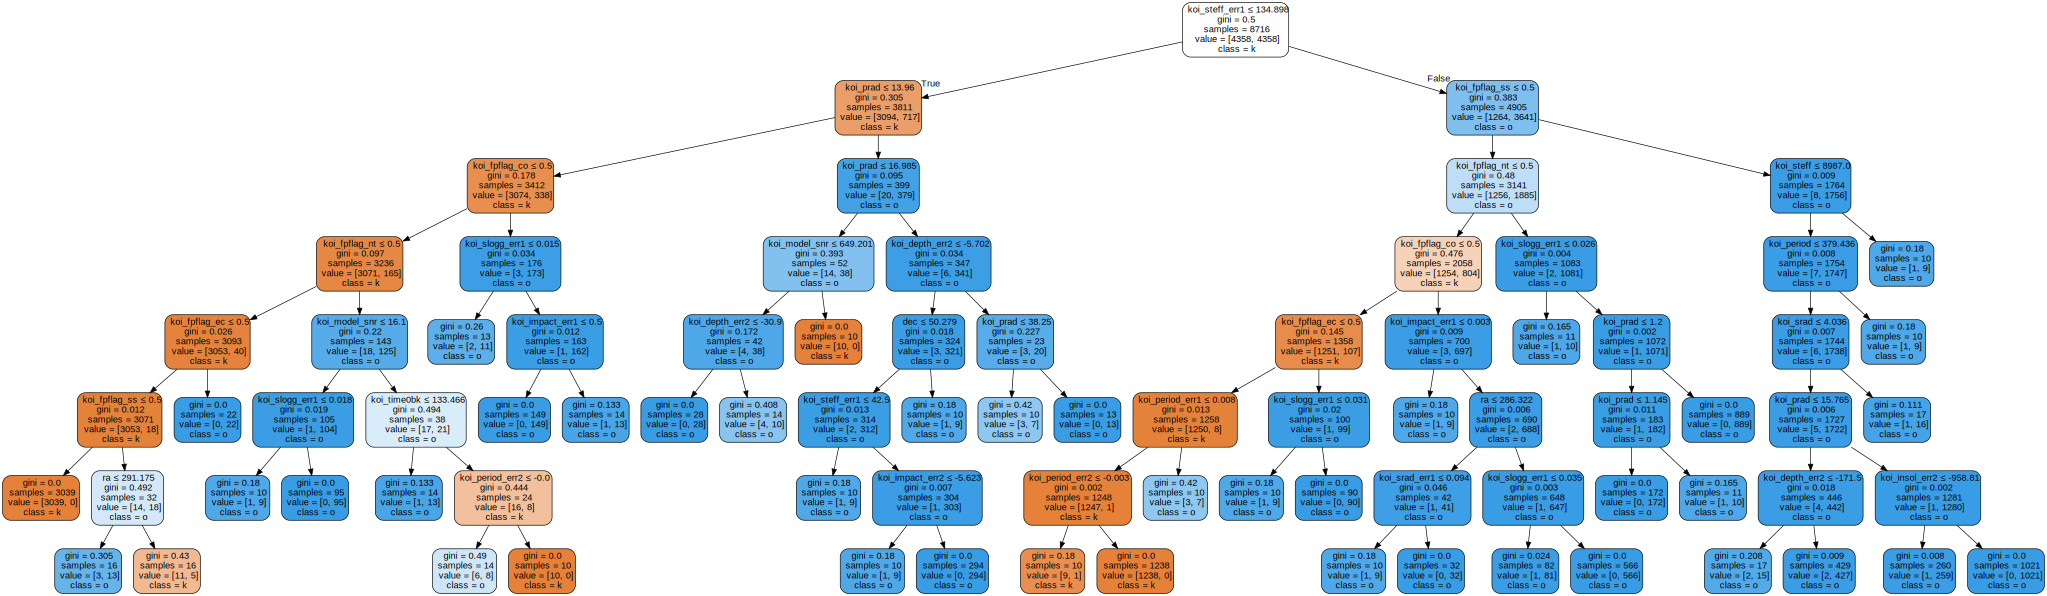

In [52]:
#visualize the tree
#graphiz doesn't work for me
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(model, out_file=None, 
                     feature_names=features,
                     class_names='koi_false_positive',
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render()
graph


In [214]:
# Now lets look at our feature importances
my_dict = {'feature_importance': model.feature_importances_,
           'feature':features }
feature_imp = pd.DataFrame.from_dict( my_dict ).sort_values('feature_importance', ascending=False)
feature_imp.head(10)

,feature_importance,feature
29,0.307582,koi_steff_err1
2,0.249033,koi_fpflag_co
0,0.169609,koi_fpflag_nt
19,0.122139,koi_prad
1,0.087117,koi_fpflag_ss
3,0.051933,koi_fpflag_ec
26,0.005823,koi_model_snr
6,0.003154,koi_period_err2
7,0.001506,koi_time0bk
37,0.000943,ra
